In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import xgboost as xgb
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def formatBacktestdata(_ccy:str):
    # Formatting
    _tarCol = ['Open time', 'Open', 'High', 'Low', 'Volume', 'Close']
    _Dir = "C:\\Users\\LCYY\\Desktop\\CrytoTrade\\Data\\Binance\\"
    _filename = '{}USDT.csv'.format(_ccy)
    _histData = pd.read_csv(_Dir + _filename, dtype={'Open time':str})[_tarCol].dropna()
    _histData['datetime'] = pd.to_datetime(_histData['Open time'], format='%Y-%m-%d %H:%M:%S')
    _histData = _histData.sort_values('datetime').reset_index(drop=True)
    _histData['date'] = _histData.datetime.dt.date
    _histData['time'] = _histData.datetime.dt.time
    _histData['symbol'] = _ccy + '/' + 'USDT'
    _histData = _histData[['datetime', 'date', 'time', 'symbol'] + _tarCol]
    _histData = _histData.drop(columns=['Open time'], axis=1)
    return _histData
    
def getRandomPeriod(_date:list, _numDays:int):
    _minDate = datetime.date(2020, 12, 31)
    _maxDate = datetime.date(2021, 10, 31)
    _startPeriod = random.choice(_date)
    _endPeriod = _startPeriod + datetime.timedelta(days=_numDays)
    if (_startPeriod >= _minDate) and (_endPeriod <= _maxDate) :
        return _startPeriod, _endPeriod
    else:
        return getRandomPeriod(_date, _numDays)

In [3]:
def Gen_Y(_close:pd.Series, _numPeriod:int):
    _closelag = (_close.shift(1)/_close)-1
    _tarRtn = abs(_closelag[_closelag < 0].mean()) * 0.5
    _Fore = pd.DataFrame(_close, columns=['Close'])
    _outY = []
    for i in range(1, _numPeriod+1):
        _Fore['Fwd_{}'.format(i)] = (((_Fore['Close'].shift(-i)/_Fore['Close'])-1))
    _Y = (_Fore.drop(['Close'], axis=1) > _tarRtn).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    return _Y
    
def Gen_backtesting_data(_ccy:str, _scalpWindow:int):
    # Load data
    _data = formatBacktestdata(_ccy)
    #_startDate, _endDate = getRandomPeriod(_date=_data.date.unique(), _numDays=90)
    _TrainStartDate, _TrainEndDate = datetime.date(2020, 12, 31), datetime.date(2021, 10, 31) 
    _TestStartDate, _TestEndDate = datetime.date(2021, 10, 31), datetime.date(2021, 12, 1) 
    _train = _data[(_data.date >= _TrainStartDate) & (_data.date <= _TrainEndDate)].reset_index(drop=True)
    _test = _data[(_data.date >= _TestStartDate) & (_data.date <= _TestEndDate)].reset_index(drop=True)
    for data in [_train, _test]:
        # Normalization
        # Return Lag
        for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
            data['Return_LAG_{}'.format(_lag)] = (data.Close/data.Close.shift(_lag)-1)
        # Realized Volatility
        for _rv in [5, 15, 30, 60, 180, 360, 720, 1440]: #[5, 30, 360, 1440]
            ann_factor = 1440 * 365 / _rv
            data['RealizedVol_Window_{}'.format(_rv)] = np.sqrt(np.square(data.Return_LAG_1).rolling(_rv).sum().clip(0,None) \
                *ann_factor)
        # ADTV
        for _adtv in [3, 5, 15, 30, 60, 180, 360, 720, 1440]: #[3, 15, 60, 180, 720]
            data['AvgVolume_Period_{}'.format(_adtv)] = data.Volume.rolling(window=_adtv).mean().shift(1)
        # Y
        _execCost = 0.0005
        data['Actual_Y'] = Gen_Y(_close=_data.Close, _numPeriod=_scalpWindow)
    # Cut First and Last Day
    _train = _train[(_train.date > _TrainStartDate) & (_train.date < _TrainEndDate)].reset_index(drop=True)
    _test = _test[(_test.date > _TestStartDate) & (_test.date < _TestEndDate)].reset_index(drop=True)
    return _train, _test
    
def Gen_backtesting_Normalization(_data:pd.DataFrame):
    # Signal
    _signaldf = pd.DataFrame(data=[x for x in _data.date], columns=['date'])
    _signaldf['time'] = _data.time
    # Return Lag
    for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
        _signaldf['Return_LAG_{}'.format(_lag)] = _data['Return_LAG_{}'.format(_lag)]
    # Realized Volatility
    RV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['RealizedVol' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['RealizedVol' in \
                          col for col in _data.columns]]].columns)
    # ADTV
    ADTV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['AvgVolume' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['AvgVolume' in \
                          col for col in _data.columns]]].columns)
    _signaldf = pd.concat([_signaldf, RV_scaled, ADTV_scaled], axis=1)
    # Y
    _signaldf['Actual_Y'] = _data['Actual_Y']
    
    return _signaldf

def GetSellingPrice(_buysignal:int, _buyPx:float, _close1:float, _close2:float, _close3:float):
    if _buysignal == 1:
        if _close1 > _buyPx:
            return _close1
        elif _close2 > _buyPx:
            return _close2
        else:
            return _close3
    else:
        return 0
    
def Gen_PnLAnalysis(_model:str, _tarCcy:str, _initialNotional:float, _executionCost:float):
    # PnL
    _predicted = pd.Series(_dataDict[_tarCcy][_model].predict(_dataDict[_tarCcy]['TestX']), name='Buy_Signal')
    _tardata = formatBacktestdata(_tarCcy)
    _close = _tardata[(_tardata.date >= datetime.date(2021, 11, 1)) & \
                (_tardata.date <= datetime.date(2021, 12, 1))].reset_index(drop=True).Close
    Plotdf = pd.concat([_dataDict[_tarCcy]['Test'].date, _dataDict[_tarCcy]['Test'].time, \
                        _dataDict[_tarCcy]['Test']['Close'], _predicted, _dataDict[_tarCcy]['Test']['Actual_Y']], axis=1)
    # Buy Price
    Plotdf['BuyPx'] = Plotdf.Close * Plotdf.Buy_Signal
    for i in range(1, _scalpingWindow+1):
        Plotdf['Close_t+{}'.format(i)] = _close.shift(-i)[:len(Plotdf)]
    # Selling Price
    Plotdf['SellPx'] = Plotdf[['Buy_Signal', 'BuyPx', 'Close_t+1', 'Close_t+2', 'Close_t+3']].apply(lambda x: 
                            GetSellingPrice(_buysignal=x[0], _buyPx=x[1], _close1=x[2], _close2=x[3], _close3=x[4]), axis=1)
    # Return
    Plotdf['Implied Return (%)'] = (Plotdf['SellPx']/Plotdf['BuyPx']-1).fillna(0) * 100
    Plotdf['MTM PnL (USD)'] = Plotdf['Implied Return (%)']/100 * _initialNotional
    Plotdf['Realized PnL (USD)'] = Plotdf['Buy_Signal'] * (Plotdf['MTM PnL (USD)'] - abs(Plotdf['MTM PnL (USD)'] * _executionCost))
    Plotdf['Realized Return (%)'] = Plotdf['Realized PnL (USD)']/_initialNotional * 100
    Plotdf['Cumulative Return (%)'] = ((Plotdf['Realized Return (%)']/100+1).cumprod()-1) * 100
    Plotdf['Realized Vol (360 Period)'] = _dataDict[_tarCcy]['Test']['RealizedVol_Window_360']
    Plotdf['Risk-Adjusted Realized Return (%)'] = Plotdf['Realized Return (%)'] / Plotdf['Realized Vol (360 Period)']
    Plotdf['Risk-Adjusted Cumulative Return (%)'] = ((Plotdf['Risk-Adjusted Realized Return (%)']/100+1).cumprod()-1) * 100
    Plotdf.index = _dataDict[_tarCcy]['Test']['datetime']
    return Plotdf

In [4]:
def vifcl(df:pd.DataFrame):
    a = 0
    i = 0
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    t = vif["VIF Factor"].max()
    for each in vif["VIF Factor"]:
        if each == t and each >= 10:
            a = i
        i += 1
    vax = vif["VIF Factor"].loc[a]
    #print(vif.loc[a],"\n>10")
    return a,vax
    
def runVIF(df:pd.DataFrame):
    # Raw train/test for VIF
    _VIF_X = df.drop(['date', 'time', 'Actual_Y'], axis=1)
    _VIF_y = df['Actual_Y']
    # First Fit
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(_VIF_X.values, i) for i in range(_VIF_X.shape[1])]
    vif["features"] = _VIF_X.columns
    vif.round(1)
    # Drop VIF>10
    dropcindex=[]
    while True:
        vmax = 0
        dropt = False
        k,s = vifcl(_VIF_X)
        if s >= 10:
            dropt = True
        if dropt == True:
            #print("dropped",_VIF_X.columns[k])
            dropcindex.append(_VIF_X.columns[k])
            _VIF_X = _VIF_X.drop([_VIF_X.columns[k]],axis=1)
            vif = vif.drop([k])
            _VIF_X = _VIF_X.reset_index(drop=True)
            vif = vif.reset_index(drop=True)
        else:
            break
    return dropcindex

# Data Preprocessing & Features Selection

In [5]:
# Param
_dataDict = {}
_scalpingWindow = 3
_ccyList = ['ADA','BNB','BTC','ETH','SOL','SAND']
# Backtesting
for _ccy in tqdm(_ccyList):
    _dataDict[_ccy] = {}
    _dataDict[_ccy]['Train'], _dataDict[_ccy]['Test'] = Gen_backtesting_data(_ccy=_ccy, _scalpWindow=_scalpingWindow)
    # Normalization
    _dataDict[_ccy]['NormalizedTrain'], _dataDict[_ccy]['NormalizedTest'] = \
        Gen_backtesting_Normalization(_data=_dataDict[_ccy]['Train']), \
            Gen_backtesting_Normalization(_data=_dataDict[_ccy]['Test'])
    # VIF
    _dataDict[_ccy]['VIFExcluded'] = runVIF(_dataDict[_ccy]['NormalizedTrain'])
    _dataDict[_ccy]['VIFIncluded'] = _dataDict[_ccy]['NormalizedTrain'].columns \
        [~_dataDict[_ccy]['NormalizedTrain'].columns.isin(_dataDict[_ccy]['VIFExcluded'])]
    _dataDict[_ccy]['NVIFTrain'] = _dataDict[_ccy]['NormalizedTrain'][_dataDict[_ccy]['VIFIncluded']]
    _dataDict[_ccy]['NVIFTest'] = _dataDict[_ccy]['NormalizedTest'][_dataDict[_ccy]['VIFIncluded']]
    # Model Fitting
    _dataDict[_ccy]['TrainX'] = _dataDict[_ccy]['NVIFTrain'].drop(['date', 'time', 'Actual_Y'], axis=1)
    _dataDict[_ccy]['TestX'] = _dataDict[_ccy]['NVIFTest'].drop(['date', 'time', 'Actual_Y'], axis=1)
    _dataDict[_ccy]['TrainY'] = _dataDict[_ccy]['NVIFTrain']['Actual_Y']
    _dataDict[_ccy]['TestY'] = _dataDict[_ccy]['NVIFTest']['Actual_Y']
    # LOGI
    _dataDict[_ccy]['Model_LOGI'] = sm.Logit(_dataDict[_ccy]['TrainY'], _dataDict[_ccy]['TrainX']) \
        .fit(solver='lbfgs', max_iter=1000, C=1e9, disp=0)
    # XGBOOST
    _XGBoostParams = {'objective': 'binary:logistic', 'eval_metric':'mlogloss', 'colsample_bytree': 0.35, \
                          'eta': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.45, 'use_label_encoder':False}
    _dataDict[_ccy]['Model_XGBoost'] = xgb.XGBClassifier(**_XGBoostParams).fit(_dataDict[_ccy]['TrainX'], \
        _dataDict[_ccy]['TrainY'])
    # PnL Analysis
    _dataDict[_ccy]['PnL_Analysis'] = Gen_PnLAnalysis(_model='Model_XGBoost', _tarCcy=_ccy, \
        _initialNotional=100000, _executionCost=0.005)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [39:47<00:00, 397.95s/it]


# VIF

In [6]:
_maxVIF = max([len(_dataDict[_ccy]['VIFExcluded']) for _ccy in _ccyList])
_VIFExclude = pd.DataFrame(index=['VIF_Feature_Excluded_{}'.format(numVIF+1) for numVIF in range(_maxVIF)], columns=_ccyList)
for _ccy in _ccyList:
    if len(_dataDict[_ccy]['VIFExcluded']) < _maxVIF:
        _VIFExclude[_ccy] = _dataDict[_ccy]['VIFExcluded'] + [np.nan]*(_maxVIF - len(_dataDict[_ccy]['VIFExcluded']))
    else:
        _VIFExclude[_ccy] = _dataDict[_ccy]['VIFExcluded']
display(pd.DataFrame(_VIFExclude.stack().value_counts(), columns=['Count']))

,Count
AvgVolume_Period_5,6
RealizedVol_Window_60,6
AvgVolume_Period_30,6
RealizedVol_Window_15,5
RealizedVol_Window_720,5
AvgVolume_Period_360,4
AvgVolume_Period_1440,4
RealizedVol_Window_180,4
AvgVolume_Period_180,2
AvgVolume_Period_720,2


# Model Fitting

In [7]:
_tarCcy = 'ADA'
_ccyData = _dataDict[_tarCcy]

In [8]:
# LOGI
print('Training Data')
# Logi-Summary
display(_ccyData['Model_LOGI'].summary())
# Confusion Matrix and Classification Report
display(confusion_matrix(_ccyData['TrainY'], (_ccyData['Model_LOGI'].predict(_ccyData['TrainX']) >= 0.5).astype(int)))
print(classification_report(_ccyData['TrainY'], (_ccyData['Model_LOGI'].predict(_ccyData['TrainX']) >= 0.5).astype(int)))
print('Testing Data')
display(confusion_matrix(_ccyData['TestY'], (_ccyData['Model_LOGI'].predict(_ccyData['TestX']) >= 0.5).astype(int)))
print(classification_report(_ccyData['TestY'], (_ccyData['Model_LOGI'].predict(_ccyData['TestX']) >= 0.5).astype(int)))

Training Data


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Actual_Y   No. Observations:               435327
Model:                          Logit   Df Residuals:                   435310
Method:                           MLE   Df Model:                           16
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                 0.01928
Time:                        18:00:10   Log-Likelihood:            -2.9593e+05
converged:                       True   LL-Null:                   -3.0174e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Return_LAG_1               4.4194      2.147      2.058      0.040       0.211       8.628
Return_LAG_2             -15.9842      2.146     -7.450      0.000     -20.189     -11.779
Return_LAG_3              -0.5998      2.146     -0.279      0.780      -4.806       3.607
Return_LAG_4               0.0903      2.144      0.042      0.966      -4.111       4.292
Return_LAG_5              13.0963      1.827      7.167      0.000       9.515      16.678
Return_LAG_7             -12.5958      1.180    -10.678      0.000     -14.908     -10.284
Return_LAG_14              3.2687      0.694      4.707      0.000       1.908       4.630
Return_LAG_28             -6.7874      0.414    -16.393      0.000      -7.599      -5.976
RealizedVol_Window_5       0.1118      0.008     14.621      0.000       0.097       0.127
RealizedVol_Window_30      0.1379      0.011     12.927      0.000       0.117       0.159
RealizedVol_Window_180     0.0707      0.010      7.309      0.000       0.052       0.090
RealizedVol_Window_720     0.0329      0.008      3.925      0.000       0.016       0.049
AvgVolume_Period_3         0.0451      0.008      5.609      0.000       0.029       0.061
AvgVolume_Period_15       -0.0130      0.010     -1.252      0.211      -0.033       0.007
AvgVolume_Period_60       -0.0409      0.009     -4.601      0.000      -0.058      -0.023
AvgVolume_Period_360      -0.0239      0.008     -2.859      0.004      -0.040      -0.008
AvgVolume_Period_1440      0.0937      0.007     13.438      0.000       0.080       0.107
==========================================================================================
"""

array([[154009,  64248],
       [121765,  95305]], dtype=int64)

              precision    recall  f1-score   support

           0       0.56      0.71      0.62    218257
           1       0.60      0.44      0.51    217070

    accuracy                           0.57    435327
   macro avg       0.58      0.57      0.56    435327
weighted avg       0.58      0.57      0.56    435327

Testing Data


array([[11407,  7681],
       [14357,  9755]], dtype=int64)

              precision    recall  f1-score   support

           0       0.44      0.60      0.51     19088
           1       0.56      0.40      0.47     24112

    accuracy                           0.49     43200
   macro avg       0.50      0.50      0.49     43200
weighted avg       0.51      0.49      0.49     43200



Training Data


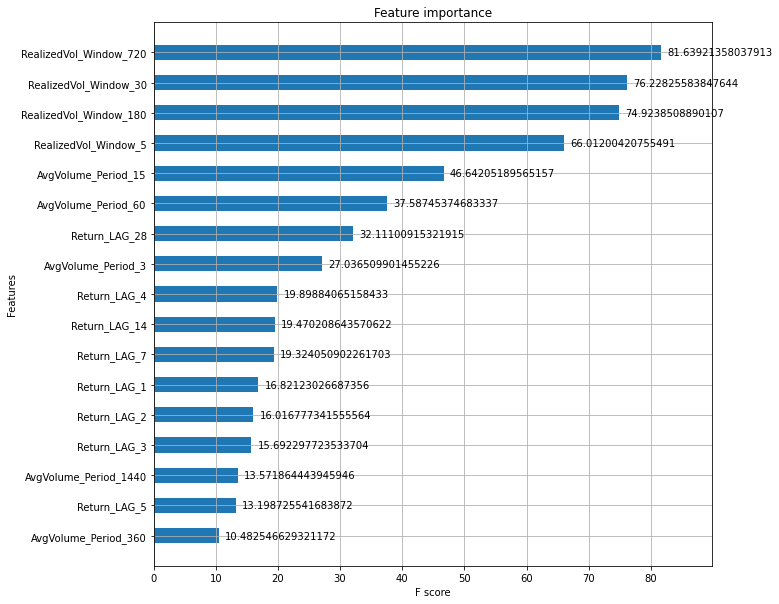

array([[123104,  95153],
       [ 85420, 131650]], dtype=int64)

              precision    recall  f1-score   support

           0       0.59      0.56      0.58    218257
           1       0.58      0.61      0.59    217070

    accuracy                           0.59    435327
   macro avg       0.59      0.59      0.59    435327
weighted avg       0.59      0.59      0.59    435327

Testing Data


array([[ 9777,  9311],
       [12392, 11720]], dtype=int64)

              precision    recall  f1-score   support

           0       0.44      0.51      0.47     19088
           1       0.56      0.49      0.52     24112

    accuracy                           0.50     43200
   macro avg       0.50      0.50      0.50     43200
weighted avg       0.51      0.50      0.50     43200



In [9]:
# XGBoost
print('Training Data')
# Signifiance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(_ccyData['Model_XGBoost'], height=0.5, ax=ax,importance_type='gain')
plt.show()
# Confusion Matrix and Classification Report
display(confusion_matrix(_ccyData['TrainY'], (_ccyData['Model_XGBoost'].predict(_ccyData['TrainX']) >= 0.5).astype(int)))
print(classification_report(_ccyData['TrainY'], (_ccyData['Model_XGBoost'].predict(_ccyData['TrainX']) >= 0.5).astype(int)))
print('Testing Data')
display(confusion_matrix(_ccyData['TestY'], (_ccyData['Model_XGBoost'].predict(_ccyData['TestX']) >= 0.5).astype(int)))
print(classification_report(_ccyData['TestY'], (_ccyData['Model_XGBoost'].predict(_ccyData['TestX']) >= 0.5).astype(int)))

# Features Significance

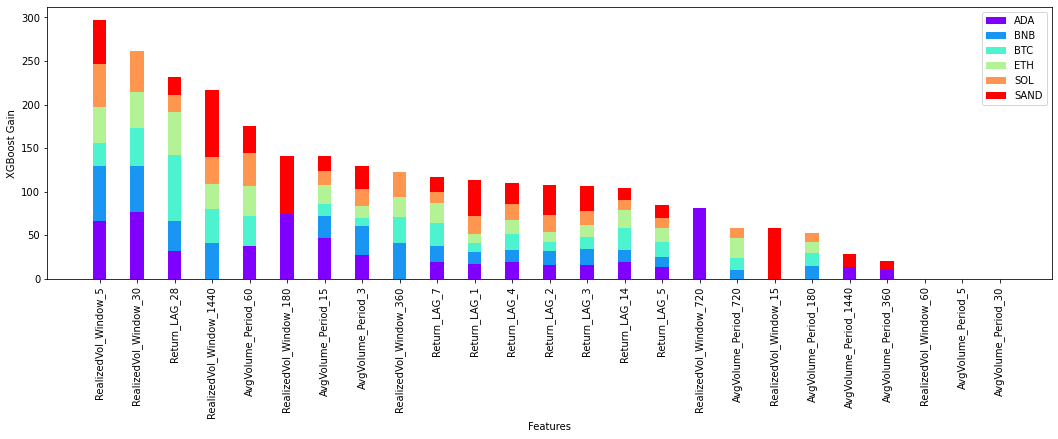

In [11]:
# Features Significance
color = plt.cm.rainbow(np.linspace(0, 1, len(_ccyList)))
_featuresSigni = pd.DataFrame(index=_dataDict[_ccyList[0]]['NormalizedTrain'].columns[~pd.Series( \
    _dataDict[_ccyList[0]]['NormalizedTrain'].columns).isin(['date', 'time', 'Actual_Y'])])
fig, ax = plt.subplots(figsize=(18, 5))
for _ccy in _ccyList:
    _featuresSigni[_ccy] = _featuresSigni.index.map(_dataDict[_ccy]['Model_XGBoost'].get_booster() \
        .get_score(importance_type='gain')).fillna(0)
_featuresSigni['Total'] = _featuresSigni.sum(axis=1)
_featuresSigni = _featuresSigni.sort_values(by=['Total'], ascending=False)
for _ccy in _ccyList:
    if _ccyList.index(_ccy) == 0:
        ax.bar(_featuresSigni.index, _featuresSigni[_ccy], 0.35, label=_ccy, color=color[_ccyList.index(_ccy)])
    else:
        ax.bar(_featuresSigni.index, _featuresSigni[_ccy], 0.35, \
               bottom=_featuresSigni.iloc[:, :_ccyList.index(_ccy)].sum(axis=1), label=_ccy, 
                   color=color[_ccyList.index(_ccy)])
plt.xlabel('Features')
plt.ylabel('XGBoost Gain') 
plt.xticks(rotation=90)
plt.legend()

# PnL Analysis

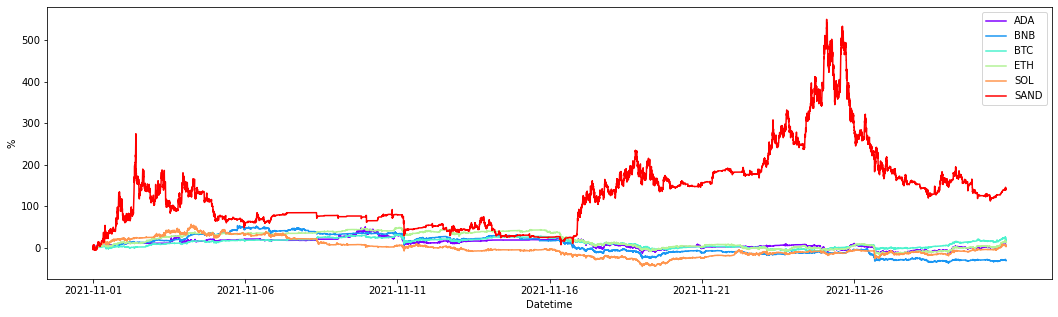

In [12]:
# Cumulative Return (%) for each ccy
fig, ax1 = plt.subplots(figsize=(18, 5))
color = plt.cm.rainbow(np.linspace(0, 1, len(_ccyList)))
for _ccy in _ccyList:
    ax1.plot(_dataDict[_ccy]['PnL_Analysis'].index, _dataDict[_ccy]['PnL_Analysis']['Cumulative Return (%)'], 
             color=color[_ccyList.index(_ccy)], label = _ccy)
plt.xticks(list(filter(lambda num: num != 0, [dt if (dt.day-1)%5 == 0 else 0 for dt in \
    _dataDict[_ccy]['PnL_Analysis'].date.unique()])))
plt.xlabel('Datetime')
plt.ylabel('%') 
plt.legend()

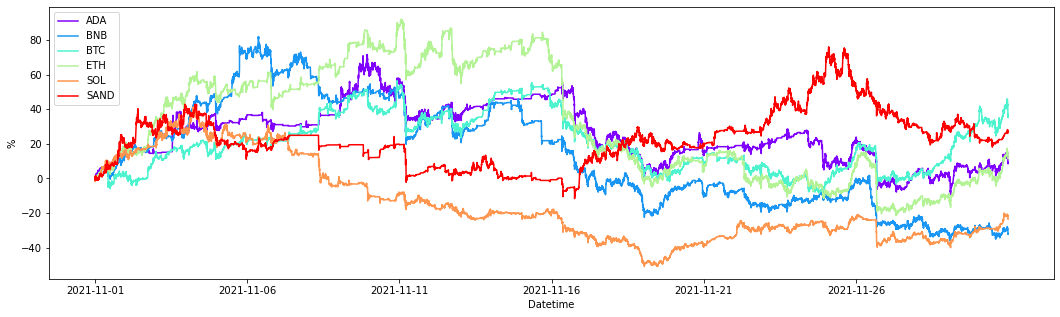

In [13]:
# Risk-adjusted Cumulative Return (%) for each ccy
fig, ax1 = plt.subplots(figsize=(18, 5))
color = plt.cm.rainbow(np.linspace(0, 1, len(_ccyList)))
for _ccy in _ccyList:
    ax1.plot(_dataDict[_ccy]['PnL_Analysis'].index, _dataDict[_ccy]['PnL_Analysis']['Risk-Adjusted Cumulative Return (%)'], 
             color=color[_ccyList.index(_ccy)], label = _ccy)
plt.xticks(list(filter(lambda num: num != 0, [dt if (dt.day-1)%5 == 0 else 0 for dt in \
    _dataDict[_ccy]['PnL_Analysis'].date.unique()])))
plt.xlabel('Datetime')
plt.ylabel('%') 
plt.legend()

ADA


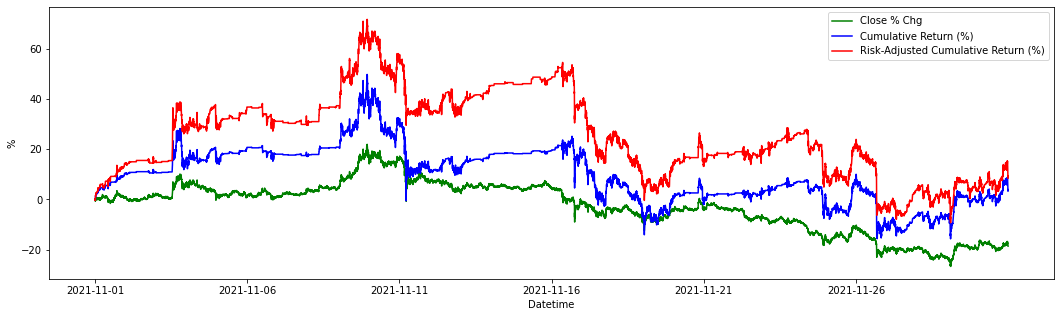

BNB


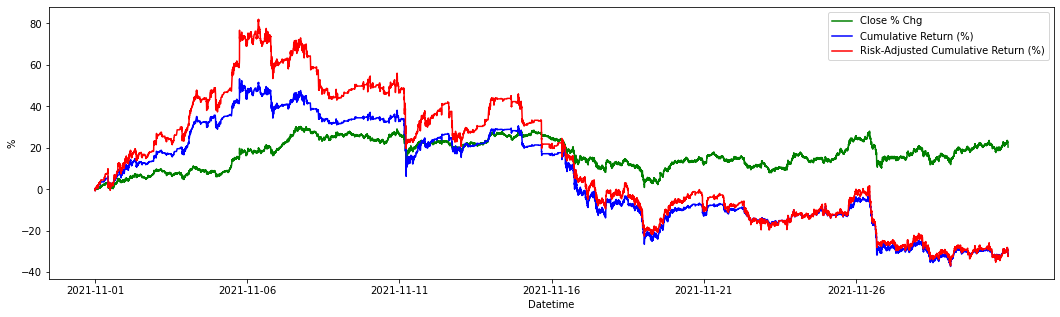

BTC


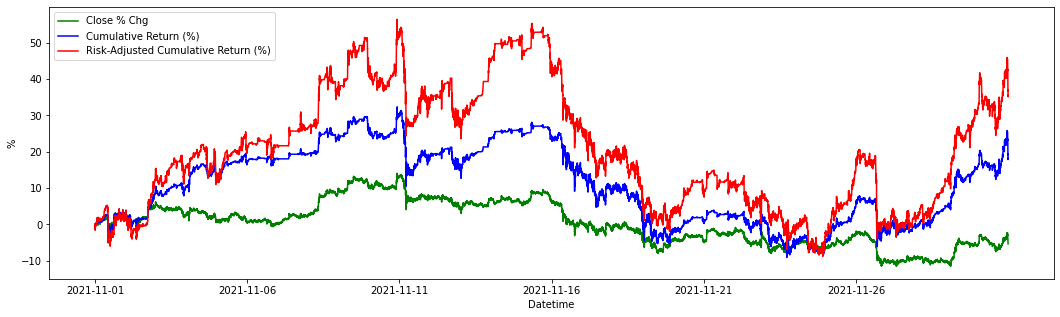

ETH


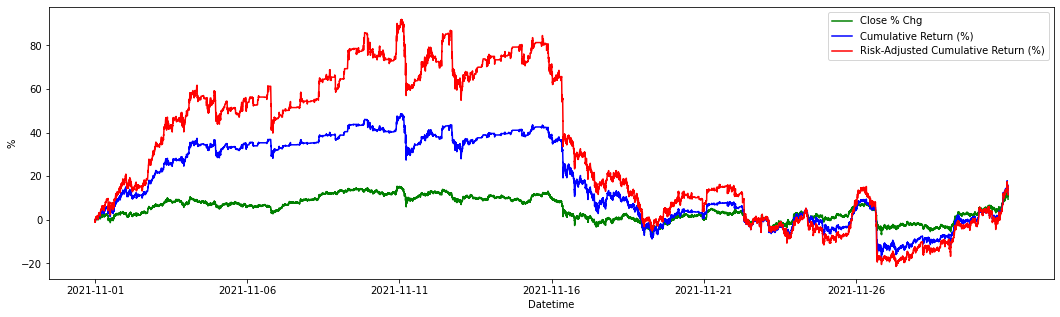

SOL


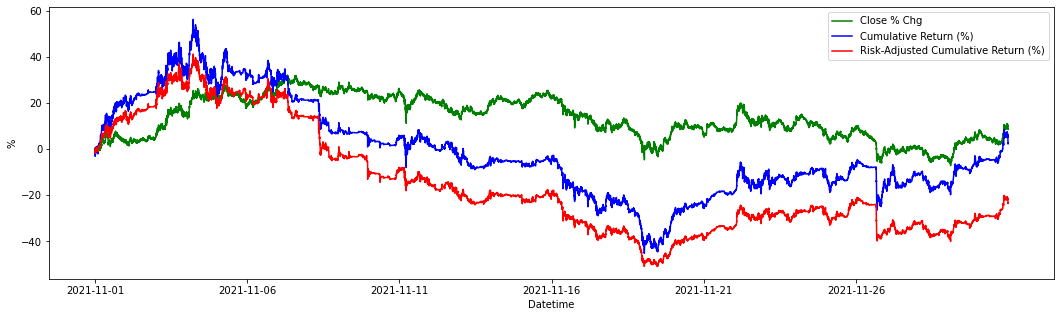

SAND


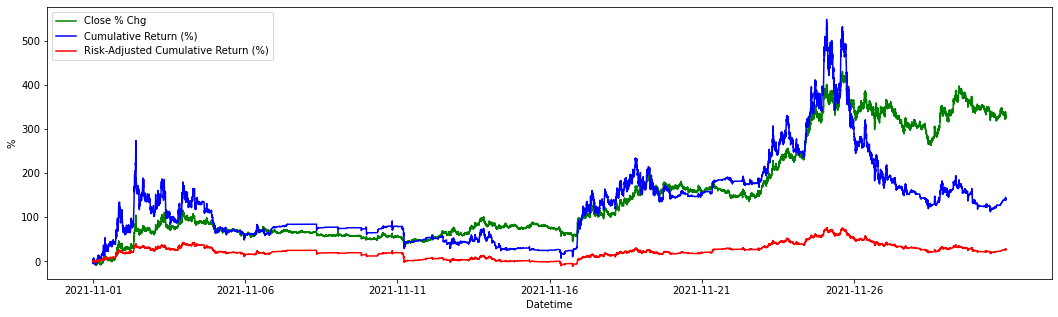

In [14]:
# Close vs Cum Return vs Risk-adjusted Cum Return
for _ccy in _ccyList:
    print(_ccy)
    PnL = _dataDict[_ccy]['PnL_Analysis']
    PnL['Close % Chg'] = (PnL.Close/PnL.Close[min(PnL.index)]-1)*100
    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax1.plot(PnL.index, PnL['Close % Chg'], 'g-', label = 'Close % Chg')
    ax1.plot(PnL.index, PnL['Cumulative Return (%)'], 'b-', label = 'Cumulative Return (%)')
    ax1.plot(PnL.index, PnL['Risk-Adjusted Cumulative Return (%)'], 'r-', label = 'Risk-Adjusted Cumulative Return (%)')
    plt.xticks(list(filter(lambda num: num != 0, [dt if (dt.day-1)%5 == 0 else 0 for dt in PnL.date.unique()])))
    plt.xlabel('Datetime')
    plt.ylabel('%') 
    plt.legend()
    plt.show()